# Imports

In [ ]:
%pip install matplotlib
%pip --no-cache-dir install numpy==1.23
%pip --no-cache-dir install pandas
%pip install -U --no-deps GPy
%pip install geopandas
%pip install gpyopt
%pip install emukit

import GPyOpt
import geopandas as gdp
import GPy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import datetime

# Gpyopt
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter, BanditParameter
from emukit.experimental_design.experimental_design_loop import ExperimentalDesignLoop
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop

from emukit.core.initial_designs import RandomDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.examples.gp_bayesian_optimization.single_objective_bayesian_optimization import GPBayesianOptimization
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement, NegativeLowerConfidenceBound, ProbabilityOfImprovement

# Decision loops 
from emukit.experimental_design import ExperimentalDesignLoop
from emukit.core.optimization.acquisition_optimizer import AcquisitionOptimizerBase


from shapely.geometry import Point

# Define optimisers and acquisitions 

In [ ]:
# brute-force optimiser for emukit
class LineSearchOptimizer(AcquisitionOptimizerBase):
    def __init__(self, space) -> None:
        super().__init__(space)

    def _optimize(self, acquisition, context_manager):
        domain = self.space._parameters[0].domain
        acq_domain = acquisition.evaluate(domain)
        idx = np.argmax(acq_domain)
        return np.array([domain[idx]]), np.array([acq_domain[idx]])
    
class LineSearchNoReplacementOptimizer(AcquisitionOptimizerBase):
    def __init__(self, space, model) -> None:
        super().__init__(space)
        self.model = model

    def _optimize(self, acquisition, context_manager):
        domain = self.space._parameters[0].domain
        model_points = self.model.X

        # handle duplicates
        delta = set(map(tuple, model_points))
        new_domain = np.array([x for x in domain if tuple(x) not in delta])

        acq_domain = acquisition.evaluate(new_domain)
        idx = np.argmax(acq_domain)
        return np.array([new_domain[idx]]), np.array([acq_domain[idx]])

# random selection acquisition 
class RandomAcquisitionOptimizer(AcquisitionOptimizerBase):
    def __init__(self, space) -> None:
        super().__init__(space)

    def _optimize(self, acquisition, context_manager):
        domain = self.space._parameters[0].domain
        acq_domain = acquisition.evaluate(domain)
        idx = np.random.randint(0, len(domain))
        return np.array([domain[idx]]), np.array([acq_domain[idx]])
    
# random selection acquisition 
class RandomAcquisitionNoReplacementOptimizer(AcquisitionOptimizerBase):
    def __init__(self, space, model) -> None:
        super().__init__(space)
        self.model = model

    def _optimize(self, acquisition, context_manager):
        domain = self.space._parameters[0].domain
        model_points = self.model.X
        
        # handle duplicates
        delta = set(map(tuple, model_points))
        new_domain = np.array([x for x in domain if tuple(x) not in delta])
        
        acq_domain = acquisition.evaluate(new_domain)
        idx = np.random.randint(0, len(new_domain))
        return np.array([new_domain[idx]]), np.array([acq_domain[idx]])

# Data loading

In [ ]:
data = pickle.load(open('data_sorted/NO2_year_2015_ratified.p', 'rb')) 

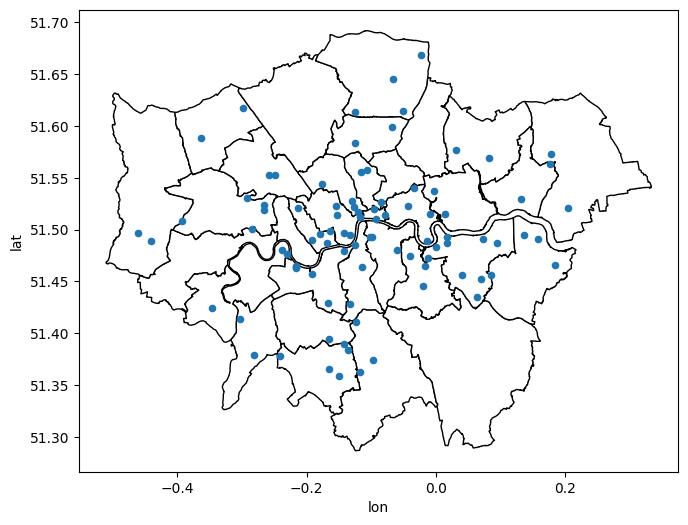

,sensor,date,pollutant,ratified,lat,lon,log_poll,norm_log_poll
0,KC3,2015-01-01,21.5,True,51.49914,-0.164338,3.068053,0.026214
1,KC3,2015-01-02,28.7,True,51.49914,-0.164338,3.356897,0.465301
2,KC3,2015-01-03,58.9,True,51.49914,-0.164338,4.075841,1.558205
3,KC3,2015-01-04,46.2,True,51.49914,-0.164338,3.832980,1.189019
4,KC3,2015-01-05,37.6,True,51.49914,-0.164338,3.627004,0.875905


In [5]:
df = pd.DataFrame(data, columns=('sensor', 'date', 'pollutant', 'ratified', 'lat', 'lon'))
map_df = gdp.read_file('london_map/London_Borough_Excluding_MHW.shp')
map_df = map_df.to_crs(epsg=4326) # change coordinates to latitude/longitude

coords = df.groupby('sensor')[['lon', 'lat']].first()
geometry = [Point(lon, lat) for lon, lat in zip(coords['lon'], coords['lat'])]
points_gdf = gdp.GeoDataFrame(coords, geometry=geometry, crs=map_df.crs)
joined = gdp.sjoin(points_gdf, map_df, op='within')
points_within_map = joined[['latitude', 'longitude']]

fig, axs = plt.subplots(figsize=(8,6))
map_df.plot(ax=axs, color='white', edgecolor='black')
points_within_map.plot.scatter(ax=axs, x='longitude', y='latitude')
plt.show()

candidate_sensors = set(points_within_map.index)
valid_sensors = df.groupby('sensor')['date'].count().reset_index()
valid_sensors['is_valid'] = (valid_sensors['date'] >= 183) & (valid_sensors['sensor'].isin(candidate_sensors))
sensor_domain = valid_sensors[valid_sensors['is_valid']]['sensor'].unique()
df = df[df['sensor'].isin(sensor_domain)]

df['log_poll'] = np.log(df['pollutant'])
log_mean, log_std = df['log_poll'].aggregate(['mean', 'std'])
df['norm_log_poll'] = (df['log_poll'] - log_mean) / log_std
df.head()

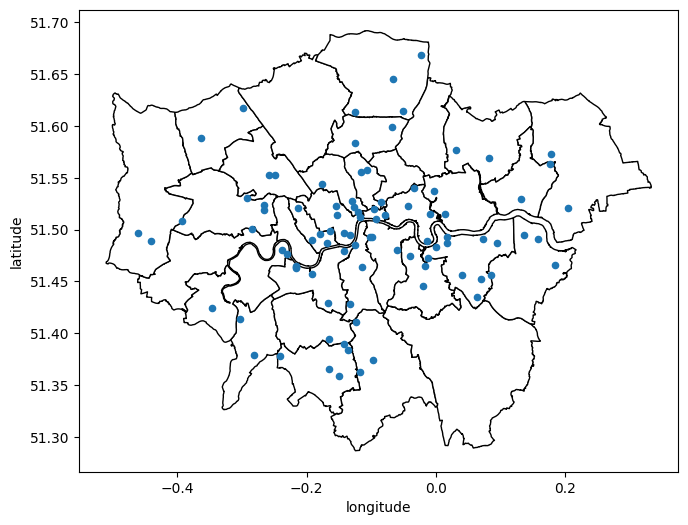

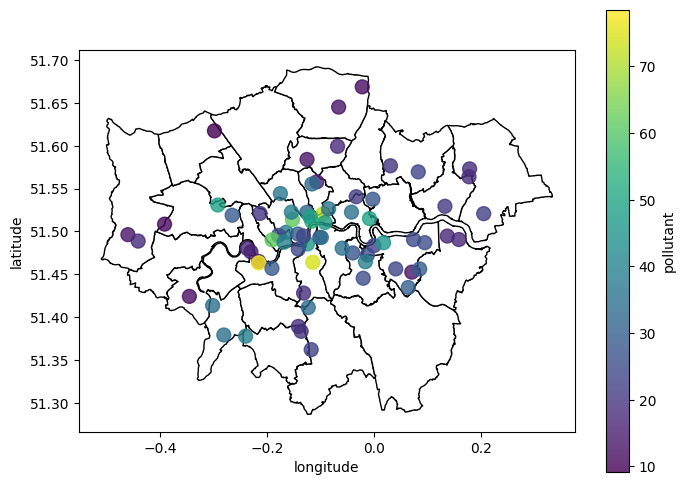

In [1389]:
fig, axs = plt.subplots(figsize=(8,6))
map_df.plot(ax=axs, color='white', edgecolor='black')
points_within_map.plot.scatter(ax=axs, x='lon', y='lat')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

map_df = gdp.read_file('london_map/London_Borough_Excluding_MHW.shp')
map_df = map_df.to_crs(epsg=4326) # change coordinates to latitude/longitude
fig, axs = plt.subplots(figsize=(8,6))
map_df.plot(ax=axs, color='white', edgecolor='black')

df[df['date'] == datetime.datetime(2015, 9, 2)].plot.scatter(x='lon', y='lat', c='pollutant', cmap='viridis', s=100, alpha=0.8, ax=axs)

plt.ylabel('latitude')
plt.xlabel('longitude')
plt.show()

In [799]:
# data for specific date
from functools import partial
generation_seed = 42
VERBOSE = False

def normalise_data(data):
    data['log_poll'] = np.log(data['pollutant'])
    log_mean, log_std = data['log_poll'].aggregate(['mean', 'std'])
    data['norm_log_poll'] = (data['log_poll'] - log_mean) / log_std
    return data, log_mean, log_std

def func(data, is_bo, coord):
    x, y = coord[0]
    sensor = data[(data['lon'] == x) & (data['lat'] == y)]
    sensor_pollution =  sensor['norm_log_poll']
    if len(sensor_pollution) == 0:
        raise Exception('Sensor reading not found')
    elif len(sensor_pollution) > 1:
        raise Exception('Multiple sensor readings')

    res = np.array(sensor_pollution).reshape(-1, 1) # emukit/GpyOpt find the minimum rather than maximum
    if VERBOSE:
        print(sensor['sensor'].iloc[0], np.round(coord[0], 2), res[0][0].round(2))
    return -1*res if is_bo else res

def plot_opt(data, loop_object, y_init, show_plot):
    xs, ys = [], []
    for i, result in enumerate(loop_object.loop_state.results):
        xs.append(result.X)
        ys.append(result.Y[0])

    best_init_Y = np.min(ys[:len(y_init)])
    ys = [best_init_Y] + ys[len(y_init):]
    xs = xs[len(y_init):]

    max_poll = data['norm_log_poll'].max()
    if show_plot:
        plt.plot([i+1 for i in range(len(ys))], np.maximum.accumulate(-1*np.array(ys) / max_poll)) # cumulative max is our estimate
        plt.axhline(y=1, color='red', linestyle='--')
        plt.show()
    return np.maximum.accumulate(-1*np.array(ys) / max_poll)

def plot_acq(loop_object):
    fig, axs = plt.subplots(figsize=(8,6))
    map_df.plot(ax=axs, color='white', edgecolor='black')
    domain = loop_object.candidate_point_calculator.acquisition_optimizer.space.parameters[0]
    acq_func = loop_object.candidate_point_calculator.acquisition.evaluate(domain)
    to_plot = pd.DataFrame(domain, columns=('lon', 'lat'))
    to_plot['acq'] = acq_func
    to_plot.plot.scatter(x='lon', y='lat', c='acq', cmap='viridis', s=100, alpha=0.8, ax=axs)
    plt.show()
    return

def create_kernel(kern_type='RBF', sum=True):
    if kern_type == 'RBF':
        kern_base = GPy.kern.RBF
    else:
        kern_base = GPy.kern.Matern32

    kern_no_sum = kern_base(input_dim=2, lengthscale=.1, ARD=False)

    kern_rbf1 = kern_base(input_dim=2, lengthscale=.1, ARD=False)
    kern_rbf1.lengthscale.constrain_bounded(0.01, 100)
    # kern_rbf1.variance.constrain_bounded(1e-3, 1e5)
    kern_rbf2 = kern_base(input_dim=2, lengthscale=1, ARD=False)
    kern_rbf2.lengthscale.constrain_bounded(0.01, 100)
    # kern_rbf2.variance.constrain_bounded(1e-3, 1e5)
    kern_white = GPy.kern.White(input_dim=2)
    #kern_white.constrain_bounded(1e-3, 1e5)
    kern_bias = GPy.kern.Bias(input_dim=2)
    # kern_bias.constrain_bounded(1e-3, 1e5)

    if sum:
        return kern_rbf1 + kern_rbf2 
    else:
        return kern_no_sum
    

# Bayesian Optimisation using Emukit

GP_regression.,value,constraints,priors
Mat52.variance,1.6472469859856786,+ve,
Mat52.lengthscale,0.0005556635578781603,+ve,
Gaussian_noise.variance,1e-10,+ve fixed,


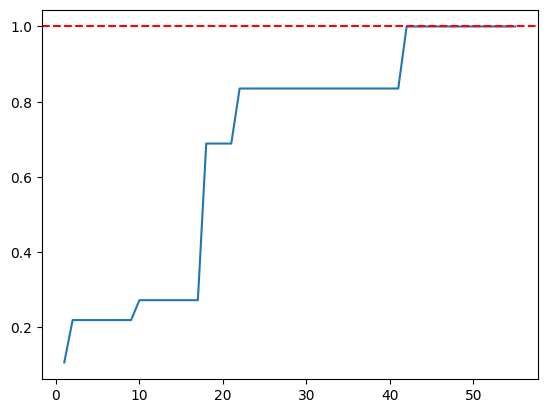

array([0.10693775, 0.21964219, 0.21964219, 0.21964219, 0.21964219,
       0.21964219, 0.21964219, 0.21964219, 0.21964219, 0.27249308,
       0.27249308, 0.27249308, 0.27249308, 0.27249308, 0.27249308,
       0.27249308, 0.27249308, 0.68883432, 0.68883432, 0.68883432,
       0.68883432, 0.83514148, 0.83514148, 0.83514148, 0.83514148,
       0.83514148, 0.83514148, 0.83514148, 0.83514148, 0.83514148,
       0.83514148, 0.83514148, 0.83514148, 0.83514148, 0.83514148,
       0.83514148, 0.83514148, 0.83514148, 0.83514148, 0.83514148,
       0.83514148, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [1454]:
np.random.seed(generation_seed)

date = datetime.datetime(2015,1,10)
df_date = df[df['date'] == date]
domain = np.array(df_date[['lon', 'lat']]) # coordinates of sensors for a given day

N_INIT = 5 # number of initial samples
p = BanditParameter('d', domain)
space = ParameterSpace([p])
design = RandomDesign(space)
func.f = partial(func, df_date, True)

VERBOSE=False

acq = ProbabilityOfImprovement
# initial points for BO
X_init = design.get_samples(N_INIT)
Y_init = np.array([func.f([x]) for x in X_init]).reshape(-1, 1)

# define surrogate model (GP)
kern = GPy.kern.Matern52(input_dim=2, ARD=False, lengthscale=.2, variance=1) 
gpy_model = GPy.models.GPRegression(X_init, Y_init, kernel=kern, noise_var=1e-10)
gpy_model.Gaussian_noise.fix()
emukit_model = GPyModelWrapper(gpy_model)

# Acquisitions
acquisition = acq(model=emukit_model)

# Design loop
bayesopt_loop = BayesianOptimizationLoop(model=emukit_model,
                                        space=space,
                                        acquisition=acquisition,
                                        acquisition_optimizer=RandomAcquisitionNoReplacementOptimizer(space, emukit_model))

# run BO loop for max_iter iterations (30 sensors in total)
max_iter = 54
bayesopt_loop.run_loop(func.f, max_iter)

#  --- / acquisition plot / ---
# plot_acq(bayesopt_loop)

display(emukit_model.model)
# print(emukit_model.model.flattened_parameters)

# --- / optimisation plot / ---
plot_opt(df_date, bayesopt_loop, Y_init, show_plot=True)

In [ ]:
VERBOSE=False
np.random.seed(generation_seed)
random_days = df['date'].sample(n=100, random_state=generation_seed)

res_bo = {'EI': [], 'PI': [], 'NLCB1': [], 'NLCB4': [], 'NLCB8': [], 'Random': []}

for rand_iter in range(1):
    for d in random_days:
        df_date = df[df['date'] == d]
        if df_date.shape[0] < 50:
            print(f'date {d} has less than 50 sensors')
            continue
        df_date, _, _ = normalise_data(df_date)
        domain = np.array(df_date[['lon', 'lat']]) # coordinates of sensors for a given day
        N_INIT = 5 # number of initial samples
        p = BanditParameter('d', domain)
        space = ParameterSpace([p])
        design = RandomDesign(space)
        func.f = partial(func, df_date, True)

        # initial points for BO
        np.random.seed(generation_seed)
        X_init = design.get_samples(N_INIT)
        Y_init = np.array([func.f([x]) for x in X_init]).reshape(-1, 1)


        for acq_str, acq in [('EI', ExpectedImprovement), ('PI', ProbabilityOfImprovement), 
                            ('NLCB1', NegativeLowerConfidenceBound), ('NLCB4', NegativeLowerConfidenceBound),
                            ('NLCB8', NegativeLowerConfidenceBound), ('Random', ExpectedImprovement)]:
            # define surrogate model (GP)
            #kern =  GPy.kern.Matern32(input_dim=2, ARD=True, lengthscale=(.2, .2), variance=1.) # + GPy.kern.White(input_dim=2)
            kern=create_kernel('Matern')
            gpy_model = GPy.models.GPRegression(X_init, Y_init, kernel=kern, noise_var=1e-10)
            gpy_model.Gaussian_noise.fix()
            emukit_model = GPyModelWrapper(gpy_model)

            if acq_str[:-1] == 'NLCB':
                acquisition = acq(model=emukit_model, beta=float(acq_str[-1]))
            else:
                acquisition = acq(model=emukit_model)

            # Design loop
            if acq_str == 'Random':
                acquisition_optimizer = RandomAcquisitionNoReplacementOptimizer(space, emukit_model)
            else:
                acquisition_optimizer = LineSearchNoReplacementOptimizer(space, emukit_model)

            bayesopt_loop = BayesianOptimizationLoop(model=emukit_model,
                                                    space=space,
                                                    acquisition=acquisition,
                                                    acquisition_optimizer=acquisition_optimizer)

            # run BO loop for max_iter iterations (30 sensors in total)
            max_iter = 45
            bayesopt_loop.run_loop(func.f, max_iter)

            #  --- / acquisition plot / ---
            # plot_acq(bayesopt_loop)

            # display(emukit_model.model)
            # print(emukit_model.model.flattened_parameters)

            # --- / optimisation plot / ---
            opt_ys = plot_opt(df_date, bayesopt_loop, Y_init, show_plot=False)
            res_bo[acq_str].append(opt_ys)

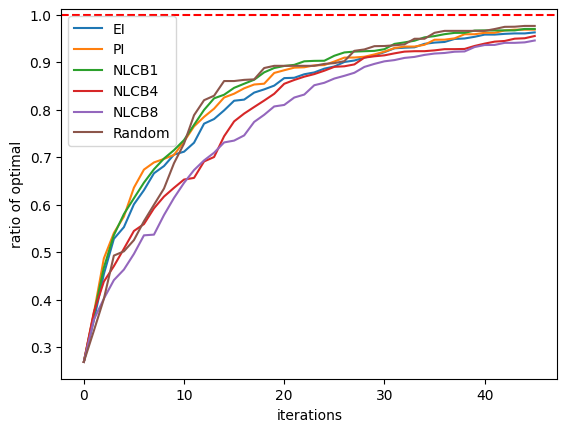

In [1346]:
plt.plot(np.mean(res_bo['EI'], axis=0), label='EI')
plt.plot(np.mean(res_bo['PI'], axis=0), label='PI')
plt.plot(np.mean(res_bo['NLCB1'], axis=0), label='NLCB1')
plt.plot(np.mean(res_bo['NLCB4'], axis=0), label='NLCB4')
plt.plot(np.mean(res_bo['NLCB8'], axis=0), label='NLCB8')
plt.plot(np.mean(res_bo['Random'], axis=0), label='Random')
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('ratio of optimal')
plt.legend()

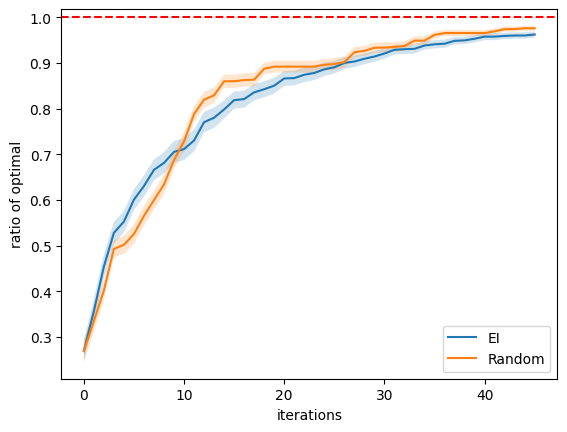

In [1352]:
plt.plot(np.mean(res_bo['EI'], axis=0), label='EI')
plt.fill_between([i for i in range(46)], np.mean(res_bo['EI'], axis=0) - np.std(res_bo['EI'], axis=0)/10, np.mean(res_bo['EI'], axis=0) + np.std(res_bo['EI'], axis=0)/10, alpha=0.2)
plt.plot(np.mean(res_bo['Random'], axis=0), label='Random')
plt.fill_between([i for i in range(46)], np.mean(res_bo['Random'], axis=0) - np.std(res_bo['Random'], axis=0)/10, np.mean(res_bo['Random'], axis=0) + np.std(res_bo['Random'], axis=0)/10, alpha=0.2)
plt.axhline(y=1, color='red', linestyle='--')
plt.xlabel('iterations')
plt.ylabel('ratio of optimal')
plt.legend()

In [1231]:
# plot functions
x_range = np.linspace(-0.6, 0.4, 100) 
y_range = np.linspace(51.25, 51.75, 100)  
x, y = np.meshgrid(x_range, y_range) 
x_flattened = x.flatten()
y_flattened = y.flatten()
points = np.column_stack((x_flattened, y_flattened))

def plot_model(loop_object):
    if isinstance(loop_object, GPRegression):
        X_eval, Y_eval = loop_object.X, loop_object.Y
        model = loop_object
    else:
        model = loop_object.model
        X_eval, Y_eval = loop_object.loop_state.X, loop_object.loop_state.Y

    if isinstance(bayesopt_loop, BayesianOptimizationLoop):
        Y_eval = Y_eval * -1

    plot_model_variance(model, X_eval, Y_eval)
    return

def plot_model_variance(model, x_eval, y_eval):
    mu, post_var = model.predict(points)
    fig, axs = plt.subplots(figsize=(8, 6))
    axs.scatter(x=x_eval[:,0], y=x_eval[:,1], c=y_eval, cmap='hot', zorder=3, s=25)
    contourf = axs.contourf(x, y, post_var.reshape(100, 100), cmap='hot', alpha=0.5, zorder=2, levels=8)
    map_df.plot(ax=axs, color='white', edgecolor='black', zorder=1, alpha=1)

    plt.colorbar(contourf, label='variance')
    plt.xlabel('longitude')
    plt.ylabel('latitude')

    plt.show()
    return

# Experimental design using Emukit

In [ ]:
N_INIT = 5
date = datetime.datetime(2015,1,3)
df_date = df[df['date'] == date]
domain = np.array(df_date[['lon', 'lat']]) # coordinates of sensors for a given day
p = BanditParameter('d', domain)
space = ParameterSpace([p])
design = RandomDesign(space)

func.f = partial(func, df_date, False)
X_init = design.get_samples(N_INIT)
Y_init = np.array([func.f([x]) for x in X_init]).reshape(-1, 1)

VERBOSE = False
# ivr_acquisition = IntegratedVarianceReduction(emukit_model, space)

for acq_opt in [LineSearchOptimizer, RandomAcquisitionOptimizer]:
    kern_matern = GPy.kern.Matern32(input_dim=2, ARD=False, lengthscale=.2, variance=1.) 
    kern_white = GPy.kern.White(input_dim=2, variance=0.1)
    kern_matern.lengthscale.constrain_bounded(0.01, 10)
    gpy_model = GPy.models.GPRegression(X_init, Y_init, kernel=kern_matern+kern_white, noise_var=1e-10)
    gpy_model.Gaussian_noise.fix()
    emukit_model = GPyModelWrapper(gpy_model)
    us_acquisition = ModelVariance(emukit_model)
    expdesign_loop = ExperimentalDesignLoop(space = space,
                                            model = emukit_model,
                                            acquisition = us_acquisition,
                                            acquisition_optimizer=acq_opt(space))

    expdesign_loop.run_loop(func.f, 25)

    display(gpy_model)
    plot_model(expdesign_loop)
    print(gpy_model.flattened_parameters)


# RMSE of generated configuration (using uncertainty sampling) versus random configuration

In [1278]:
def fit_gpy(f, kern, iterations, x_init, y_init, acq_opt, noise_var=1e-10, fix_noise=True):
    np.random.seed(generation_seed)
    gpy_model = GPy.models.GPRegression(x_init, y_init, kernel=kern, noise_var=noise_var)
    if fix_noise:
        gpy_model.Gaussian_noise.fix()
    emukit_model = GPyModelWrapper(gpy_model)
    us_acquisition = ModelVariance(emukit_model)
    expdesign_loop = ExperimentalDesignLoop(space=space,
                                            model=emukit_model,
                                            acquisition=us_acquisition,
                                            acquisition_optimizer=acq_opt(space, emukit_model))

    try:
        expdesign_loop.run_loop(f, iterations)
    except:
        pass

    #gpy_model.plot()
    # plot_model(expdesign_loop)
    print(f'SENSORS FITTED: {len(np.unique(expdesign_loop.loop_state.X, axis=0))}')
    #print(gpy_model.flattened_parameters)
    return expdesign_loop


In [ ]:
res = {'model': [], 'random': [], 'all': []}
VAL_SENSORS = 20
VERBOSE = False
iter_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
np.random.seed(generation_seed)

random_days = df['date'].sample(n=100, random_state=generation_seed)
for i, d in enumerate(random_days):
    np.random.seed(generation_seed)
    df_date = df[df['date'] == d]
    sensor_hold_out = df_date['sensor'].sample(20).values
    df_date_train = df_date[~df_date['sensor'].isin(sensor_hold_out)]
    print(f'{len(df_date_train)} training sensors || iteration {i}')
    df_date_val = df_date[df_date['sensor'].isin(sensor_hold_out)]
    domain = np.array(df_date_train[['lon', 'lat']]) # coordinates of sensors for a given day
    eval_points = np.array(df_date_val[['lon', 'lat']])

    # normalisation
    df_date_train, log_mean_tr, log_std_tr = normalise_data(df_date_train)
    df_date_val['log_poll'] = np.log(df_date_val['pollutant'])
    df_date_val['norm_log_poll'] = (df_date_val['log_poll'] - log_mean_tr) / log_std_tr

    N_INIT = 5 # number of initial samples
    p = BanditParameter('d', domain)
    space = ParameterSpace([p])
    design = RandomDesign(space)
    func.f = partial(func, df_date_train, False)
    X_init = design.get_samples(N_INIT)
    Y_init = np.array([func.f([x]) for x in X_init]).reshape(-1, 1)
    all_model = GPy.models.GPRegression(domain, np.array(df_date_train['norm_log_poll']).reshape(-1,1), kernel=create_kernel('Matern'), noise_var=.1)
    # all_model.Gaussian_noise.fix()
    all_model.optimize()

    mu_all, var_all = all_model.predict(eval_points)
    error_all = np.sqrt(np.mean(((mu_all.squeeze() - df_date_val['norm_log_poll'])**2)))

    for iterations in iter_list:
        # print('----/// ALL SENSORS ///-----')
        # print(all_model.flattened_parameters)

        print('/// ---------- ///')
        print(f'DATE = {d} || MODEL = US')
        us_model = fit_gpy(func.f, create_kernel('Matern'), iterations, X_init, Y_init, LineSearchNoReplacementOptimizer, noise_var=.1, fix_noise=False)
        print('/// ---------- ///')
        print(f'DATE = {d} || MODEL = RANDOM')
        rand_model = fit_gpy(func.f, create_kernel('Matern'), iterations, X_init, Y_init, RandomAcquisitionNoReplacementOptimizer, noise_var=.1, fix_noise=False)
        print('/// ---------- ///')

        us_model_sensors = len(np.unique(us_model.loop_state.X, axis=0))
        rand_model_sensors = len(np.unique(rand_model.loop_state.X, axis=0))

        if us_model_sensors < iterations/2 or rand_model_sensors < iterations/2:
            print(f'Date {d} has {us_model_sensors} sensors by US and {rand_model_sensors} by random sampling; ignoring')
            continue

        mu, var = us_model.model.model.predict(eval_points)
        mu_rand, var_rand = rand_model.model.model.predict(eval_points)
    
        error_model = np.sqrt(np.mean(((mu.squeeze() - df_date_val['norm_log_poll'])**2)))
        error_rand = np.sqrt(np.mean(((mu_rand.squeeze() - df_date_val['norm_log_poll'])**2)))

        res['model'].append((us_model, iterations, error_model))
        res['random'].append((rand_model, iterations, error_rand))
        res['all'].append((all_model, iterations, error_all))

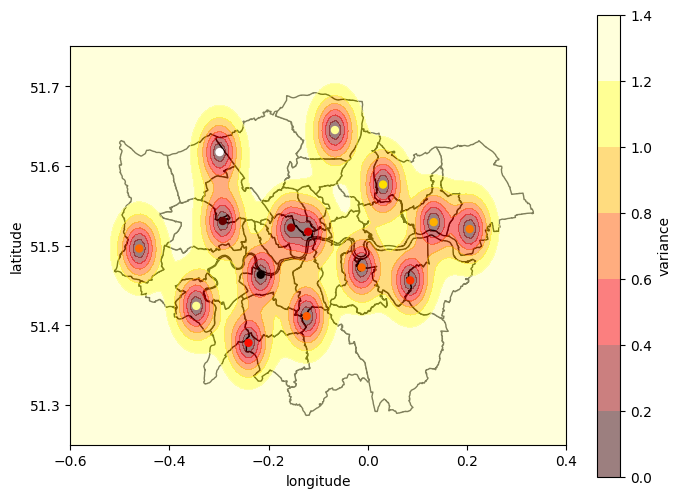

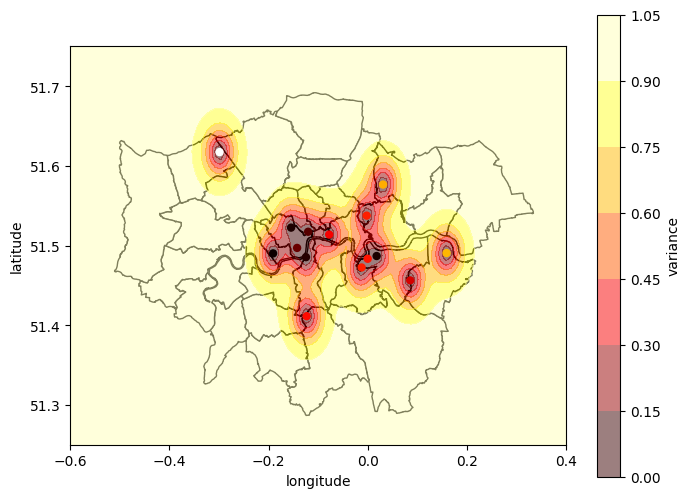

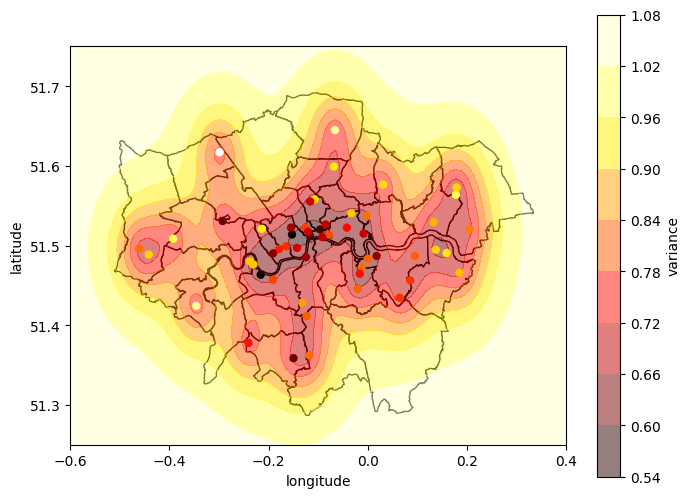

15 15


In [1341]:
us_model_test = [x for x,y,z in res['model'] if y == 10][0]
rand_model_test = [x for x,y,z in res['random'] if y == 10][0]
all_model_test = [x for x,y,z in res['all'] if y == 10][0]


plot_model(us_model_test), plot_model(rand_model_test), plot_model(all_model_test)

print(len(us_model_test.loop_state.X), len(rand_model_test.loop_state.X))

In [1358]:
res_err = []
model_res_err = []
rand_res_err = []
for iteration in iter_list:
    model_err = np.mean([z for x,y,z in res['model'] if y == iteration])
    all_err = np.mean([z for x,y,z in res['all'] if y == iteration])
    rand_err = np.mean([z for x,y,z in res['random'] if y == iteration])

    model_err_lb = np.mean([z for x,y,z in res['model'] if y == iteration]) - np.std([z for x,y,z in res['model'] if y == iteration])/10
    model_err_ub = np.mean([z for x,y,z in res['model'] if y == iteration]) + np.std([z for x,y,z in res['model'] if y == iteration])/10
    
    rand_err_lb = np.mean([z for x,y,z in res['random'] if y == iteration]) - np.std([z for x,y,z in res['random'] if y == iteration])/10
    rand_err_ub = np.mean([z for x,y,z in res['random'] if y == iteration]) + np.std([z for x,y,z in res['random'] if y == iteration])/10
    
    model_res_err.append((model_err, model_err_lb, model_err_ub))
    rand_res_err.append((rand_err, rand_err_lb, rand_err_ub))
    print(np.mean([z for x,y,z in res['model'] if y == iteration]), np.mean([z for x,y,z in res['all'] if y == iteration]), np.mean([z for x,y,z in res['random'] if y == iteration]))

1.0089526580604076 0.9111285162624104 1.0089526580604076
0.9958222866808407 0.9111285162624104 0.994540065638052
1.0285897452163848 0.9111285162624104 0.9847349026257145
1.0119150017156284 0.9111285162624104 0.9760554072639693
1.0012814241423749 0.9111285162624104 0.9854524946002176
1.0091753134643011 0.9111285162624104 0.9946109550293297
0.997682426018866 0.9111285162624104 0.982002075517419
0.9907501028579994 0.9111285162624104 0.9760168109843572
0.9742880956017081 0.9111285162624104 0.9737942441199562
0.9686032708238334 0.9111285162624104 0.9678898188663466


In [1353]:
res_err_bounds = []
for iteration in iter_list:
    model_err = np.std([z for x,y,z in res['model'] if y == iteration])
    all_err = np.std([z for x,y,z in res['all'] if y == iteration])
    rand_err = np.std([z for x,y,z in res['random'] if y == iteration])

    res_err_bounds.append([model_err, all_err, rand_err])

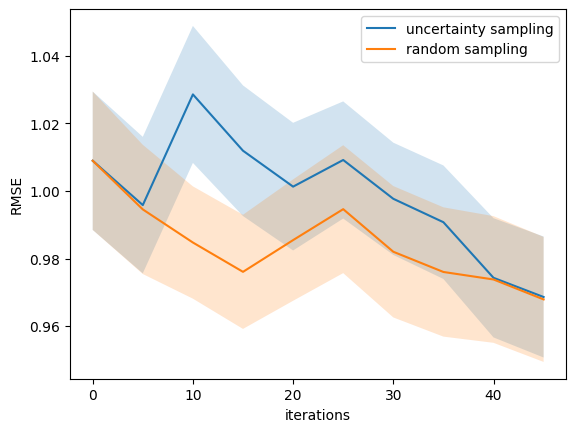

In [1368]:
plt.plot(iter_list, [x for x,y,z in model_res_err])
plt.plot(iter_list, [x for x,y,z in rand_res_err])
plt.legend(['uncertainty sampling', 'random sampling'])
plt.xlabel('iterations')
plt.ylabel('RMSE')

plt.fill_between(iter_list, [y for x,y,z in model_res_err], [z for x,y,z in model_res_err], alpha=0.2)
plt.fill_between(iter_list, [y for x,y,z in rand_res_err], [z for x,y,z in rand_res_err], alpha=0.2)


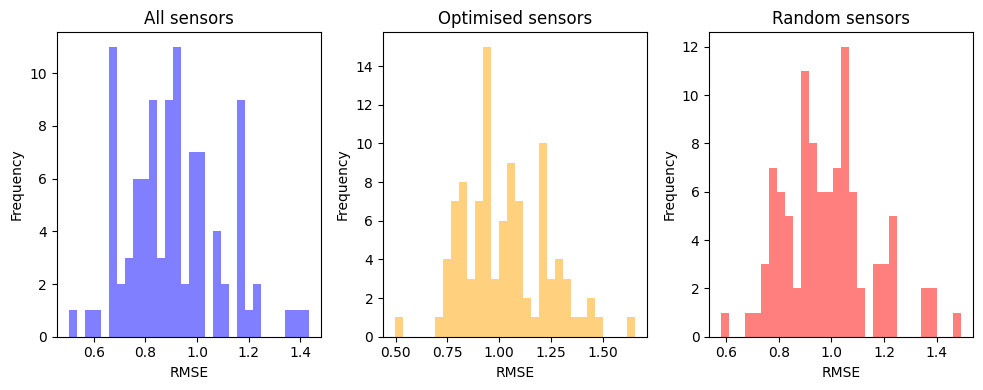

In [1343]:
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

all_err = [z for x,y,z in res['all'] if y == 10]
model_err = [z for x,y,z in res['model'] if y==10]
rand_err = [z for x,y,z in res['random'] if y==10]

# Plot histograms
axes[0].hist(all_err, bins=30, alpha=0.5, color='blue')
axes[1].hist(model_err, bins=30, alpha=0.5, color='orange')
axes[2].hist(rand_err, bins=30, alpha=0.5, color='red')

# Add labels and title to each subplot
axes[0].set_xlabel('RMSE')
axes[0].set_ylabel('Frequency')
axes[0].set_title('All sensors')

axes[1].set_xlabel('RMSE')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Optimised sensors')

axes[2].set_xlabel('RMSE')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Random sensors')

# Adjust layout
plt.tight_layout()
plt.show()

# all > optimised > random whcih is more or less expected. But also, the errors are not too great in all cases.
# the model (probably the kernel) is potentially not reflecting reality too much